# Optimization of a robotic crane
This hands-on exercise is a part of the Geilo Winter School 2022 on continuous optimization.

Continuous optimization is an important area of robotics. Methods and algorithms for optimization helps us to, e.g., reduce energy usage, increase performance, and increase accuracy in robot operations. In this hands-on exercise we give an example on how optimization can be used in robotics and some of the important aspects of optimization – such as "cost functions" and "constraints". You'll learn about cost functions, constraints and more in the rest of this exercise.

**Learning goals:**  
- Understand how a <mark>mathematical model</mark> of a robot can be used to produce optimal control algorithms for planning and control.
- Understand the concept of <mark>cost functions</mark> and <mark>constraints</mark> in optimization problems and how they are used.
- Familiarize with how to use an optimization solver.

---

<div class="alert alert-block alert-info">
This is an online Jupyter notebook. Notebooks integrate Python code, text and plots in a single convenient file, split into "cells".
Use the "Run" button (or press shift+enter) to step through the code below. It is important that ALL cells are run in sequence.
We use Binder to launch the notebook online, such that we can run Python code remotely in the cloud instead of locally.

Note: if the notebook is inactive for some time the process that runs the notebook will disconnect and you will get a "kernel dead" message (this is because the code runs on a server in the cloud somewhere and disconnect to free up resources if you are not using it). If this happens, just simply press "restart" and run through the code from the top again.
</div>

<div class="alert alert-block alert-danger">
Warning: the changes you make to the notebook is only local to your machine, so if you close the tab and open the link again you will get a new empty project. Instead open the generated address to your notebook(looks like this: https://hub.gke2.mybinder.org/user/martiabr-crane-optimization-xxxxxxxx/notebooks/crane-optimization-extended.ipynb). It is also recommended to save your changes locally by going to File -> Download as -> Notebook (.ipybn) and opening the notebook file later.
</div>

---

### Introducing the problem:
We will be studying an overhead crane operating from the ceiling of a production facility. The crane is big and heavy, and it is therefore very important that the tip of the crane is accurately controlled such that we get fast, safe and efficient production.

To this end, for this hands-on task we will consider using <mark>trajectory optimization</mark> to control the overhead crane. The crane has a overhead cart with horizontal position called $r$ and an angle $\theta$ down to the payload hanger of the crane, as seen in the figure below. The crane has velocity $\dot{r}$ and the payload has an angular velocity $\dot{\theta}$. We let $x = [r \ \theta \ \dot{r} \ \dot{\theta}]$ be the "states" of our system, which we want to control. We can push the "cart" with a force $F$ and will try to find a way to decide $F$ over time such that we move the crane system from the "Start" position to the "Target" position while minimizing speed and force. 

<img src="../crane_fig.png" alt="crane" width="800"/>

The crane pendulum has length $\ell$, the mass of the "cart" is $m_1$, the mass of the load is $m_2$ and the gravity is $g$.

### Trajectory optimization:

<div class="alert alert-block alert-info">
<b>Trajectory optimization, briefly:</b>
Optimization is a general framework for minimizing/maximizing some function (subsequently called a cost function), while adhering to constraints. In trajectory optimization we apply optimization to find some optimal trajectory/path for a system, such as a robot, drone, rocket, or in our case, crane. By designing a cost function such that some performance metric for the system is minimized, while considering the dynamics of our system and possibly additional constraints, this can be achieved.
</div>

For our first example we will simply tell the optimizer to minimize the distance to our target position, while trying to reduce the velocity of the crane. We write this mathematically like this:
$$J = R_r (r - r_t)^2 + R_\theta \theta^2 + R_{\dot{r}} \dot{r}^2 + R_{\dot{\theta}} \dot{\theta}^2.$$

This function is called a *cost function* and since this function is to be minimized, the optimization system will simultaneously try to bring the horizontal position of the cart $r$ to the target $r_t$, while also bringing the angle $\theta$ to the down position (zero). $R_r$ and $R_\theta$ are weights that describe how we weigh these two goals against each other. I.e., if $R_r$ is much bigger than $R_\theta$, then the crane trajectory optimizer will prioritize getting the cart to the target position, and give less priority to getting the crane angle to zero. Small penalities are also added on the velocities $ \dot{r}$ and $\dot{\theta}^2$ with weights $R_{\dot{r}}$ and $R_{\dot{\theta}}$.

We will minimize this cost function over a time horizon of 4 seconds – i.e., our crane trajectory optimizer will look up to 4 seconds into the future and optimize the crane movement for this time period. We could have set a longer period, but this would have required more compute power in order to solve the optimization problem.

The complete optimization problem will look like this:
\begin{aligned}
    \min_{u} \quad & \sum_{i=0}^{N-1}{R_r (r_i - r_t)^2 + R_\theta \theta_i^2} + R_{\dot{r}} \dot{r}_i^2 + R_{\dot{\theta}} \dot{\theta}_i^2 \\
    \textrm{s.t.} \quad & x_{k+1} = f_d(x_k, u_k) \quad \forall k = 0, 1, \dots, N-1 \\
    & x_0 = x(0)    \\
\end{aligned}
We optimize our cost function over the duration of $N$ time steps, while adhering to the dynamics of our system given by the function $f_d$. We also add the constraint $x_0 = x(0)$ to make sure our solution starts in the initial condition $x(0)$.

An important part of our optimization problem above is to understand how our system will behave. To this end, we need to make a mathematical model of the crane systems. This mathematical model is given to our optimization problem, such that it can take into account how the crane will move when it plans our desired motion.

Now let's add some code to do this. There is no need to read through the code to follow the main aspects this hands-on exercise.

First we need some imports and other boilerplate things:

In [69]:
# Enable nice plots:
%matplotlib inline

# Imports:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle, Circle
from matplotlib import rcParams, animation
import casadi as cs
from IPython.display import HTML

# Center figures:
from IPython.core.display import HTML
HTML("""
<style>
.output_subarea {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

The mathematical model of our crane system will first be defined. It can be expressed in the form:
$$M(\theta) \begin{bmatrix}\ddot{r} \\ \ddot{\theta} \end{bmatrix} + h(\theta, \dot{\theta}) = u.$$
The details of the model are not important for understanding the rest of the exercise. However, for completeness, it can be shown that the mass matrix $M$ is:
$$M(\theta) = \begin{bmatrix} m_1 + m_2 & m_2 \ell \cos(\theta) \\ m_2 \ell \cos(\theta) & m_2 \ell^2 \end{bmatrix}$$
the vector for the Coriolis and gravitational terms $h$ is:
$$\quad h(\theta, \dot{\theta}) = \begin{bmatrix} -m_2 \ell \dot{\theta}^2 \sin{\theta} \\ m_2 g \ell \sin{\theta} \end{bmatrix}$$
and the control input to our system $u$, i.e., the variable which we can use to control the motion of our crane system, is:
$$\quad u = \begin{bmatrix} F \\ 0 \end{bmatrix}.$$

<div class="alert alert-block alert-warning">
<b>Exercise 0 (optional, for the mathematically minded):</b> derive the model for the crane system. Hint: find the Lagrangian $\mathcal{L} = T - V$ of the system, where $T$ is kinetic energy and $V$ potential energy, in terms of the horizontal position $r$ and the angle of the payload hanger $\theta$, and use the Euler-Lagrange equations:
    $$\frac{d}{dt}\frac{\partial \mathcal{L}}{\partial \dot r} = \frac{\partial \mathcal{L}}{\partial r}, \quad \frac{d}{dt}\frac{\partial \mathcal{L}}{\partial \dot \theta} = \frac{\partial \mathcal{L}}{\partial \theta}.$$
Hint 2: Remember that potential energy from the variable force $F$ equals $\int_{t_0}^t F \dot r dt$.
</div>


In order to simulate our system we rewrite it to the form:
$$\begin{bmatrix}\ddot{r} \\ \ddot{\theta} \end{bmatrix} = M(\theta)^{-1} \left(u - h(\theta, \dot{\theta})\right).$$
This equation can then be included as a constraint in an optimization problem in order to find physically feasible motions. 

In this exercise, we will use CasADi (https://web.casadi.org/), an open-source tool for solving optimal control porblems. In order to compute derivatives of complex, nonlinear expressions, CasADi uses a symbolic framework that implements both forward and backward automatic differentiation.

We start by setting up the necessary variables and functions for describing the dynamics of the problem.

In [70]:
# Create symbolic variables for the state variables and input variable:
r = cs.SX.sym('r')                          # Position of cart
theta = cs.SX.sym('theta')                  # Angle of pendulum
r_dot = cs.SX.sym('r_dot')                  # Velocity of cart
theta_dot = cs.SX.sym('theta_dot')          # Angular velocity of pendulum
x = cs.vertcat(r, theta, r_dot, theta_dot)  # x is the vector of the four states: x = [r, theta, r_dot, theta_dot]
u = cs.SX.sym('F')                          # u is the input, i.e., the force F

# Parameters:
m_1 = 5.0           # mass of the cart
m_2 = 1.0           # mass of the load
l = 1.0             # length of the pendulum
g = 9.81            # gravity
r_pendulum = 0.08   # radius of the circular load (not used in model but used later)

def generate_cont_dynamics(m_1, m_2, l, g):
    # Inverse mass matrix:
    M_inv = cs.SX(2,2)
    M_inv[0,0] = m_2 * l**2
    M_inv[0,1] = - m_2 * l * cs.cos(theta)
    M_inv[1,0] = - m_2 * l * cs.cos(theta)
    M_inv[1,1] = m_1 + m_2
    M_inv = M_inv / ((m_1 + m_2) * m_2 * l**2 - m_2**2 * l**2 * cs.cos(theta)**2)

    # Vector of gravity + coriolis terms:
    h = cs.SX(2,1)
    h[0,0] = -m_2 * l * theta_dot**2 * cs.sin(theta)
    h[1,0] = m_2 * l * g * cs.sin(theta)

    x_dot = cs.vertcat(x[2:], M_inv @ (cs.vertcat(u, 0) - h))  # formulate dynamics (time derivative of states)
    f = cs.Function('f', [x, u], [x_dot])
    return f

# We integrate the dynamics one time step dt into the future using the 4th order Runge-Kutta method
# in order to get a model that can be included in the optimization problem:
def integrate_RK4(x_k, u_k, f, dt):
    k1 = f(x_k, u_k)
    k2 = f(x_k + dt * k1 / 2.0, u_k)
    k3 = f(x_k + dt * k2 / 2.0, u_k)
    k4 = f(x_k + dt * k3, u_k)
    return x_k + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)

def generate_disc_dynamics(m_1, m_2, l, g, dt):
    f = generate_cont_dynamics(m_1, m_2, l, g)
    f_d = cs.Function('f', [x, u], [integrate_RK4(x, u, f, dt)])  # discrete dynamics
    return f_d

dt = 0.05  # optimizer time step
f = generate_cont_dynamics(m_1, m_2, l, g)
f_d = generate_disc_dynamics(m_1, m_2, l, g, dt)

<div class="alert alert-block alert-warning">
<b>Exercise 1:</b> Write a function for computing the optimal force $F$ in order to move the crane from an initial position to a terminal position. You can use the skeleton provided below, and start by inserting the correct cost function.
</div>

In [88]:
def optimize_crane(N, x_0, r_t, R_F=0, use_term_constraint=False, F_max=None, theta_max=None, opts={}):
    # N:   Number of control segments
    # x_0: Initial state
    # r_t: Terminal position
    # Weights:
    R_r = 100
    R_theta = 100
    R_r_dot = 1
    R_theta_dot = 1
    # Maximum and minimum force
    if F_max is None: F_max = cs.inf

    # Cost function (syntax: cs.Function(name, variables, expression))
    J_k = cs.Function('J_k', [x, u], [0])
    
    # Start with an empty NLP (nonlinear program):
    U = []            # Control
    U_0 = np.zeros(N) # Initial guess
    lbu = []          # Control lower bound
    ubu = []          # Control upper bound
    J = 0             # Cost
    g = []            # Constraint
    lbg = []          # Constraint lower bound 
    ubg = []          # Constraint upper bound

    X_k = cs.SX(x_0)
    for k in range(N):
        # Control input at step k:
        U_k = cs.SX.sym('U_' + str(k))
        U += [U_k]
        
        # Control input constraints go here

        X_k = f_d(X_k, U_k)     # integrate to get state at time step k
        J += dt * J_k(X_k, U_k) # add cost at time step k to cost over entire time horizon

        # Add state constraint
        if theta_max is not None:
            g
            # State constraints go here

    # Add terminal constraint:
    if use_term_constraint:
        g
        # Terminal constraints go here

    # Create an NLP solver:
    nlp = {'f': J, 'x': cs.vertcat(*U), 'g': cs.vertcat(*g)}
    solver = cs.nlpsol('solver', 'ipopt', nlp, opts)

    # Solve the NLP:
    sol = solver(x0=U_0, lbx=lbu, ubx=ubu, lbg=lbg, ubg=ubg)
    u_sol = sol['x']
    obj = solver.stats()['iterations']['obj']
    return u_sol, obj

You can test the function with the following code.

In [75]:
r_0     = -0.5 # Initial position
theta_0 = 0.0
N = 80    # number of control segments
r_t = 0.5 # target position

x_0 = np.array([r_0, theta_0, 0.0, 0.0])   # initial state (r, theta, r_dot, theta_dot)
F_opt, cost = optimize_crane(N, x_0, r_t)  # find the optimal force over time F_opt

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       80
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

Above you will see the output from the solver we are using(IPOPT). We can see the number of iterations the solver used, and the value of the cost (objective) function at these iterations. We also get some information about the timing of the solver.

We then add some code for simulating the crane (i.e., to calculate the dynamics of the crane over time based on the mathematical model of the crane we defined earlier): 

In [76]:
N_sim   = 1000  # number of simulation steps 
dt_sim  = 0.005 # Time step of simulation in seconds 
r_0     = -0.5  # Initial position
theta_0 = 0.0   # Initial angle
x_0 = np.array([r_0, theta_0, 0.0, 0.0]) # Initial state (r, theta, r_dot, theta_dot)

def simulate_crane(x_0, u, N_sim):
    k_u = int(dt/dt_sim)
    x_sim = np.zeros((N_sim+1,4))
    x_sim[0,:] = x_0
    u_sim = np.zeros(N_sim)
    for k in range(N_sim):
        if k < k_u * N: u_sim[k] = u[int(k/k_u)]
        x_sim[k+1] = np.array(integrate_RK4(x_sim[k], u_sim[k], f, dt_sim)).squeeze()
    return x_sim, u_sim

Finally we need some code for plotting/visualizing the simulation results:

In [77]:
rcParams['lines.linewidth'] = 2

def plot_cost(cost):
    plt.figure()
    plt.plot(np.log10(cost), color='crimson')
    plt.title('Cost function')

def plot_results(x_sim, u_sim, F_max=None, theta_max=None):
    t = np.array([dt_sim*i for i in range(N_sim)])
    
    # Plot control input:
    fig, ax = plt.subplots(figsize=(8,4))
    ax.step(t, u_sim, where='post', c='teal')
    if F_max is not None:
        ax.plot([0, np.max(t)], F_max * np.ones(2), '--', c='darkmagenta', alpha=0.7)
        ax.plot([0, np.max(t)], -F_max * np.ones(2), '--', c='darkmagenta', alpha=0.7)
    ax.set_title('Force input')
    ax.set_xlabel(r'$t$ (s)')
    ax.set_ylabel(r'$F$ (N)')

    # Plot state variables:
    fig, ax = plt.subplots(2,2, figsize=(10,5))
    fig.suptitle('States')
    
    ax[0,0].plot(t, x_sim[:N_sim,0], c='mediumblue')
    ax[0,0].plot([0, np.max(t)], r_t * np.ones(2), '--', c='crimson', alpha=0.7)
    ax[0,0].set_ylabel(r'$r$ (m)')
    ax[0,0].set_xlabel(r'$t$ (s)')
    
    ax[0,1].plot(t, x_sim[:N_sim,1], c='mediumblue')
    ax[0,1].plot([0, np.max(t)], np.zeros(2), '--', c='crimson', alpha=0.7)
    if theta_max is not None:
        ax[0,1].plot([0, np.max(t)], theta_max * np.ones(2), '--', c='darkmagenta', alpha=0.7)
        ax[0,1].plot([0, np.max(t)], -theta_max * np.ones(2), '--', c='darkmagenta', alpha=0.7)
    ax[0,1].set_ylabel(r'$\theta$ (rad)')
    ax[0,1].set_xlabel(r'$t$ (s)')

    ax[1,0].plot(t, x_sim[:N_sim,2], c='mediumblue')
    ax[1,0].plot([0, np.max(t)], np.zeros(2), '--', c='crimson', alpha=0.7)
    ax[1,0].set_ylabel(r'$\dot{r}$ (m/s)')
    ax[1,0].set_xlabel(r'$t$ (s)')
    
    ax[1,1].plot(t, x_sim[:N_sim,3], c='mediumblue')
    ax[1,1].plot([0, np.max(t)], np.zeros(2), '--', c='crimson', alpha=0.7)
    ax[1,1].set_ylabel(r'$\dot{\theta}$ (rad/s)')
    ax[1,1].set_xlabel(r'$t$ (s)')

    plt.show()

def show_animation(x_sim, obstacle=False):
    skips = 10
    frames = int(N_sim / skips)
    delay = skips*dt_sim*1e3

    rect_height = 0.15
    beam_height = 0.05

    fig, ax = plt.subplots(figsize=(8,5))

    line_1, = ax.plot([-1.2,1.2], [0,0], 'k--', alpha=0.7, lw=1.5)
    rect_1 = ax.add_patch(Rectangle((-1, -0.5*beam_height), 2, beam_height, facecolor='firebrick', edgecolor='k', lw=2))
    rect_2 = ax.add_patch(Rectangle((x_sim[0,0] - 0.2, 0.5*rect_height), 0.4, rect_height, facecolor='indianred', edgecolor='k', lw=2))

    x_pendulum = x_sim[0,0] + l * np.sin(x_sim[0,1])
    y_pendulum = -l * np.cos(x_sim[0,1])
    line_2, = ax.plot([x_sim[0,0], x_pendulum], [0, y_pendulum], '-o', c='k', lw=3, ms=6)
    circle_1 = ax.add_patch(Circle([x_pendulum, y_pendulum], radius=r_pendulum, facecolor='darkorange', edgecolor='k', lw=2))
    
    if obstacle:
        circle_2 = ax.add_patch(Circle([x_obstacle, y_obstacle], radius=r_obstacle, facecolor='orangered', edgecolor='k', lw=2))
    
    line_3, = ax.plot([r_0, r_0], [-l,0], 'k--', alpha=0.7, lw=1.5)
    line_4, = ax.plot([r_t, r_t], [-l,0], 'k--', alpha=0.7, lw=1.5)

    plt.axis('equal')
    plt.xlim([-1, 1])
    plt.ylim([-l - 0.35, 0.35])

    def animate(i):
        rect_2.set_xy([x_sim[skips*i,0] - 0.2, 0.0 - 0.5*rect_height])
        
        x_pendulum = x_sim[skips*i,0] + l * np.sin(x_sim[skips*i,1])
        y_pendulum = -l * np.cos(x_sim[skips*i,1])
        
        circle_1.center = [x_pendulum, y_pendulum]
        line_2.set_data([x_sim[skips*i,0], x_pendulum], [0, y_pendulum])
        
        return line_2, circle_1, rect_2
    
    plt.close()

    return animation.FuncAnimation(fig, animate, frames=frames, interval=delay, blit=True)

Let's first plot the cost versus iteration from the optimization we just ran

/tmp/ipykernel_12594/391746997.py:5: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(cost), color='crimson')


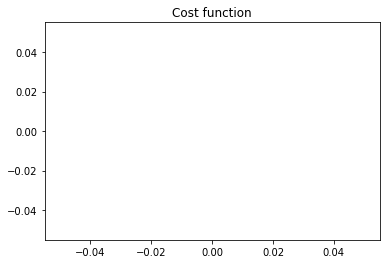

In [78]:
plot_cost(cost)

Now let's try to simulate the crane system using the force sequence we found and see how it behaves:

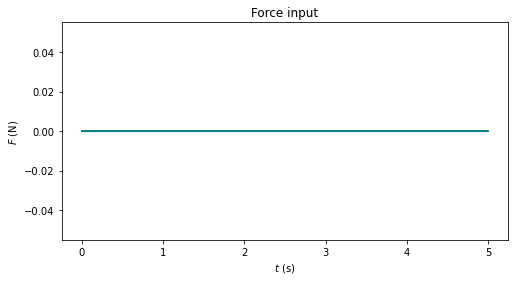

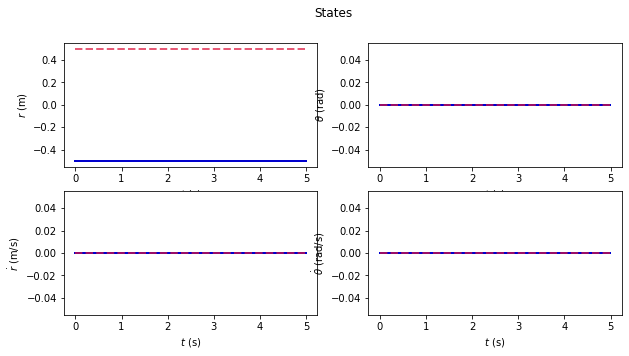

In [79]:
x_sim, u_sim = simulate_crane(x_0, F_opt, N_sim) # simulate the crane system using F_opt to control the crane
plot_results(x_sim, u_sim)                       # plot the simulation results

In [80]:
HTML(show_animation(x_sim).to_jshtml())

Let's pause here for a bit and have a look at the above plots and animation.

- The top plot ("Force input") shows the force applied to the cart-module of the crane.
- The two left-most figures show the position and the speed of the cart.
- The two right-most figures shows the angle and angular velocity of the payload of the crane.

So, that didn't go too well in terms of stabilizing the crane and its payload. We see from the plots that the payload of the crane does not fully stabilize in it's target position.

We also see that initially the crane jumps forward with a very large force. This would not be good for our crane and would probably not meet the safety requirements for our autonomous crane.

So far we have only told the optimizer to minimize the distance to the desired state of the crane system. But we see from the above example that we should also try to minimize how large force we are using to push the cart with. This will hopefully give us smoother and safer crane motions. This can be achieved by adding the term $R_F F^2$ to the cost function. The new cost function then looks like this:
$$J = R_r (r - r_t)^2 + R_\theta \theta^2 + R_{\dot{r}} \dot{r}^2 + R_{\dot{\theta}} \dot{\theta}^2 + R_F F^2$$


<div class="alert alert-block alert-warning">
<b>Exercise 2:</b> Modify <tt>optimize_crane</tt> to incorporate penalization of large forces.
    
Try to change the value of the weight (to e.g. 0.01, 0.1, 1, 10,...) in the code block below and see how it affects the resulting motion. Try to find a suitable value that weights the two tasks against each other appropriately. Write a function for computing the optimal force $F$ in order to move the crane from an initial position to a terminal position. You can use the skeleton provided below, and start by inserting the correct cost function.
</div>

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       80
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

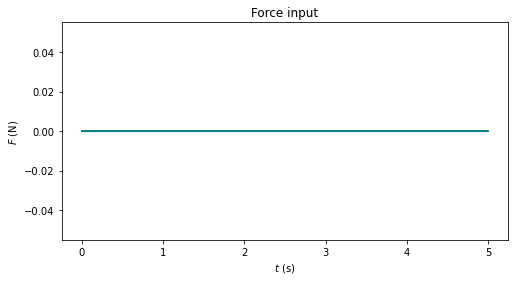

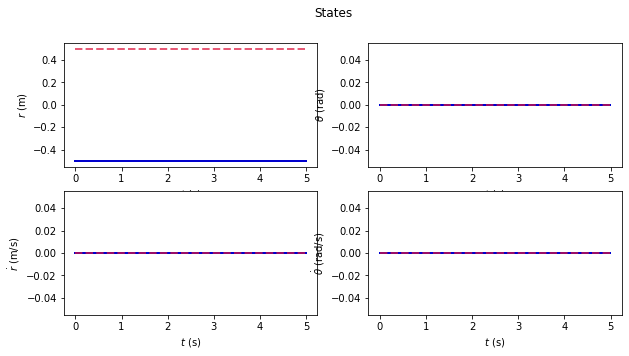

In [81]:
# Try to change the force weight and see the effect:
force_weight = 0.1

F_opt, cost = optimize_crane(N, x_0, r_t, R_F=force_weight)
x_sim, u_sim = simulate_crane(x_0, F_opt, N_sim)
plot_results(x_sim, u_sim)
HTML(show_animation(x_sim).to_jshtml())

That hopefully looks much smoother. For the remaining tests we will use a weight of 0.1.

***

### Adding a terminal constraint:
But we have another problem: the crane pendulum doesn't hit our target exactly! It wiggles around, but ideally we want it to end perfectly at rest at its target position.

One way of solving this is to add a <mark>terminal constraint</mark>. This means that we constrain the position and angle of our crane on the final time step at $t = 4s$ to be exactly at the target, while also saying that the final velocity should be zero. This can be written like:
$$r_f = r_t, \quad \theta_f = 0, \quad \dot r_f = \dot \theta_f = 0,$$
where $r_f$ and $\theta_f$ are the final position and final angle, respectively, and $\dot r$ and $\dot \theta_f$ are the final linear and angular velocity, respectively.

<div class="alert alert-block alert-warning">
<b>Exercise 3:</b> Modify <tt>optimize_crane</tt> to incorporate a terminal constraint. Hint: You can see how to define constraint in nonlinear programs in CasADi in the <a href="https://web.casadi.org/docs/#nonlinear-programming"> documentation</a>.

</div>

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       80
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

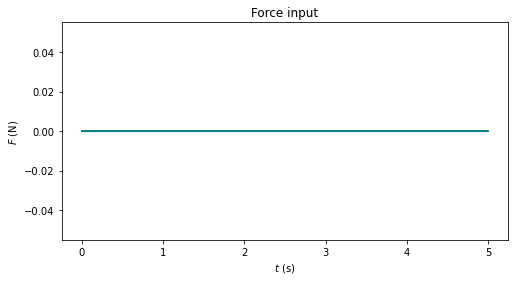

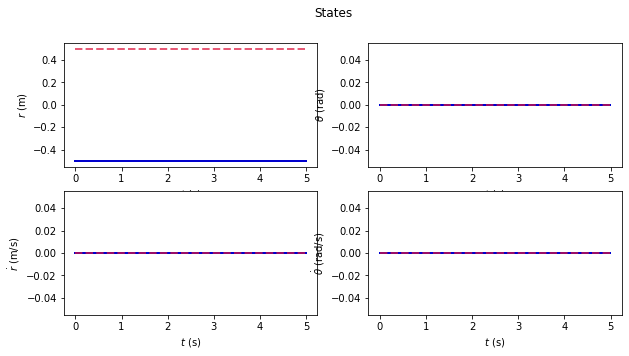

In [82]:
force_weight = 0.1
F_opt, cost = optimize_crane(N, x_0, r_t, R_F=force_weight, use_term_constraint=True)
x_sim, u_sim = simulate_crane(x_0, F_opt, N_sim)
plot_results(x_sim, u_sim)
HTML(show_animation(x_sim).to_jshtml())

---

### Adding input constraints:

Ok, but what if we have a *finite* maximum force we can push the overhead cart with? One of the main reasons why optimization is so popular in robotics applications is that such constraints can be seamlessly added to the optimization problem!

<div class="alert alert-block alert-warning">
<b>Exercise 4:</b> Modify <tt>optimize_crane</tt> to incorporate a input constraints on the form $-F_{\textrm{max}} \leq F \leq F_{\textrm{max}}$, meaning that the force should stay within a range specified by a max force $F_{\textrm{max}}$. See what happens when you vary $F_{\textrm{max}}$. 
</div>

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       80
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       80
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/tmp/ipykernel_12594/391746997.py:5: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(cost), color='crimson')


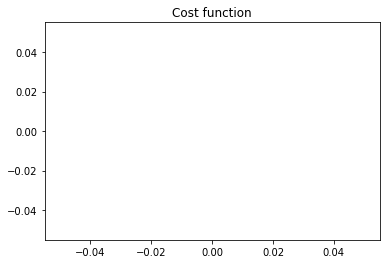

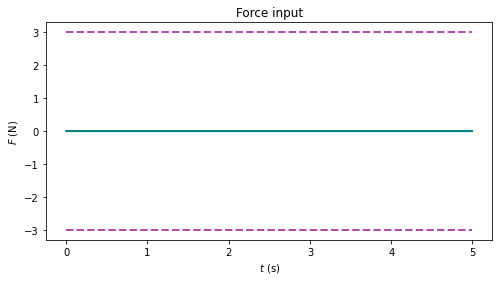

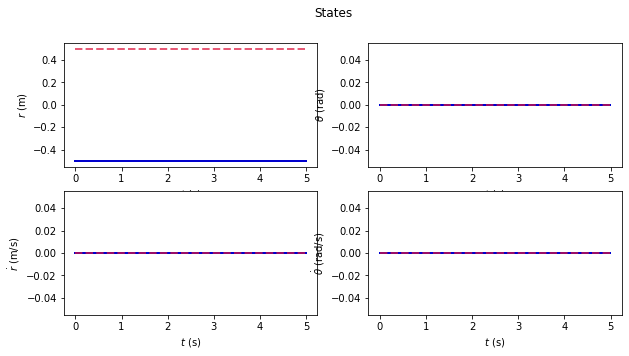

In [83]:
F_max = 3.0

F_opt, cost = optimize_crane(N, x_0, r_t, R_F=force_weight, use_term_constraint=True, F_max=F_max)
plot_cost(cost)
x_sim, u_sim = simulate_crane(x_0, F_opt, N_sim)
plot_results(x_sim, u_sim, F_max=F_max)
HTML(show_animation(x_sim).to_jshtml())

From the first plot we see that the force is restricted to $[-3,3]$, while still achieving the main goal of reaching the target!

---
### A closer look at the solver:
Now that we have a working crane, let's have a closer look at the solver.

We see that we use 12 iterations to solve the problem with the IPOPT solver. Typically solvers terminate when either the error is below the <mark>solver tolerance</mark> or they hit the maximum number of iterations. Try to change the tolerance and max iterations and see how it influences the result.

You can also experiment with using a limited-memory quasi-Newton Hessian approximation instead of an exact Hessian and see how that influences the computation time. 

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       80
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       80
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/tmp/ipykernel_12594/391746997.py:5: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(cost), color='crimson')


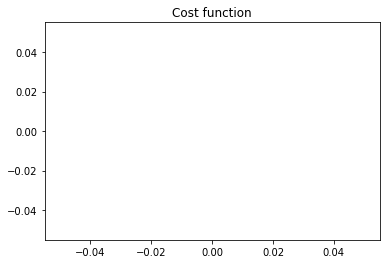

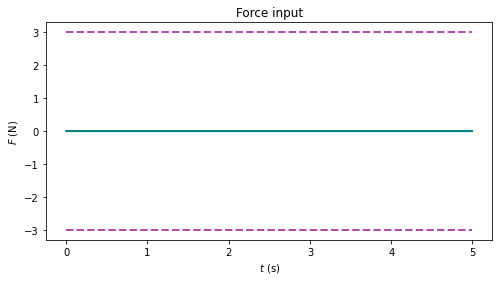

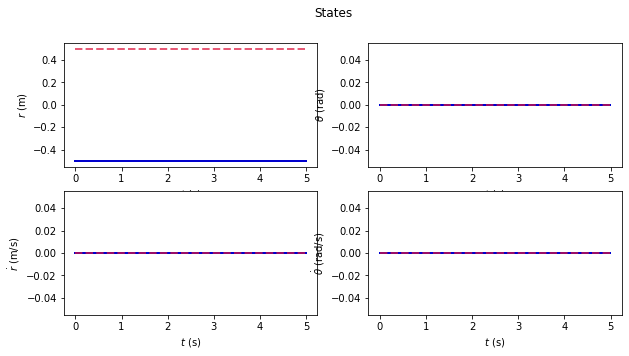

In [84]:
tolerance = 1e-8
max_iterations = 20
hessian_approximation = 'exact'  # 'exact' or 'limited-memory'

options = {'ipopt.tol': tolerance, 'ipopt.max_iter': max_iterations, 'ipopt.hessian_approximation': hessian_approximation}
F_opt, cost = optimize_crane(N, x_0, r_t, R_F=force_weight, use_term_constraint=True, F_max=F_max, opts=options)
plot_cost(cost)
x_sim, u_sim = simulate_crane(x_0, F_opt, N_sim)
plot_results(x_sim, u_sim, F_max=F_max)
HTML(show_animation(x_sim).to_jshtml())

---

### Adding state constraints:
Now you may ask, can we also add constraints to the state variables? Yes, we can! Eg. what if we want to limit the angle $\theta$ as well? We can write the constraint like this:
$$-\theta_{\textrm{max}} \leq \theta \leq \theta_{\textrm{max}},$$
and say we for instance want to limit the angle to $\theta_{\textrm{max}} = 4 \ \textrm{deg}$. Let's run another example with this constraint added (instead of the input constraint):

<div class="alert alert-block alert-warning">
<b>Exercise 5:</b> Modify <tt>optimize_crane</tt> to incorporate constraints on the form $-\theta_{\textrm{max}} \leq \theta \leq \theta_{\textrm{max}}$, meaning that the angle should stay within a range specified by a max $\theta_{\textrm{max}}$. See what happens when you vary $\theta_{\textrm{max}}$. 
</div>

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       80
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

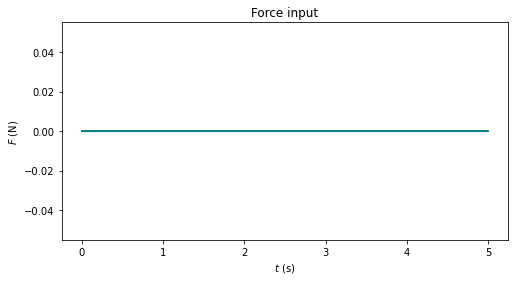

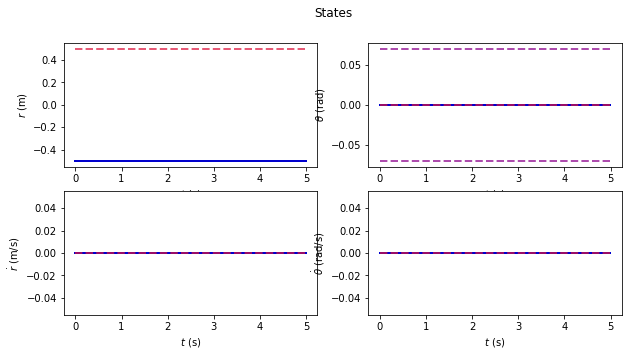

In [85]:
# Vary the maximum angle
theta_max = np.deg2rad(4)

F_opt, cost = optimize_crane(N, x_0, r_t, R_F=force_weight, use_term_constraint=True, theta_max=theta_max)
x_sim, u_sim = simulate_crane(x_0, F_opt, N_sim)
plot_results(x_sim, u_sim, theta_max=theta_max)
HTML(show_animation(x_sim).to_jshtml())

Nice! From the top right plot of $\theta$ we see that the angle of the crane pendulum stays within the specified limits.

---

Before moving on to the final task, feel free to play around with the different parameters to see how it affects the motion of the system in the following code block (you can change weights, mass and length of pendulum, initial conditions, target, bounds on force, angle, etc...).

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       80
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

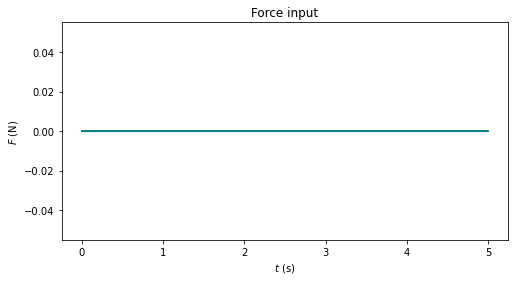

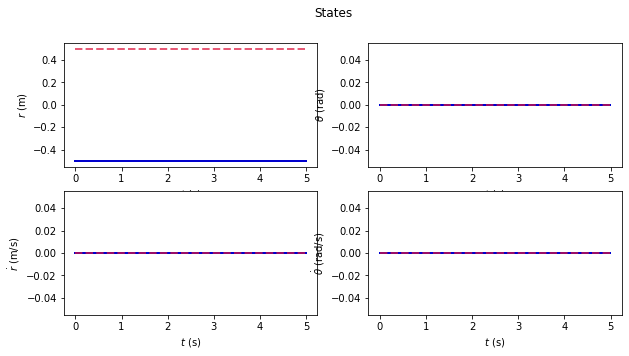

In [86]:
# Parameters:
m_1 = 5.0           # mass of the cart
m_2 = 1.0           # mass of the load
l = 1.0             # length of the pendulum
g = 9.81            # gravity
N = 80              # number of control segments
r_t = 0.5           # target position
r_0 = -0.5
theta_0 = 0.0
r_dot_0 = 0.0
theta_dot_0 = 0.0
x_0 = np.array([r_0, theta_0, r_dot_0, theta_dot_0])   # initial state (r, theta, r_dot, theta_dot)


f = generate_cont_dynamics(m_1, m_2, l, g)
f_d = generate_disc_dynamics(m_1, m_2, l, g, dt)
F_opt, cost = optimize_crane(N, x_0, r_t, R_F=force_weight, use_term_constraint=True)
x_sim, u_sim = simulate_crane(x_0, F_opt, N_sim)
plot_results(x_sim, u_sim)
HTML(show_animation(x_sim).to_jshtml())

---

### Collision avoidance:
As a final challenge we will consider how to add collision avoidance to our robotic crane. There is now a circular obstacle in the way between the start position and goal position, with position $x_o = 0.25, y_o=-1.0$ and radius $r_o=0.1$.

<img src="../crane_fig_obstacle.png" alt="crane" width="800"/>

<div class="alert alert-block alert-warning">
    <b>Exercise 6:</b> Create a new function <tt>optimize_crane_obstacle</tt> that also supports an additional constraint to our optimization problem such that the crane load (which is a circle with radius $r_l=0.08$) avoids the obstacle on its way to the goal position with an additional safety distance $\epsilon = 0.02$.

Hint: Try to express the distance between the crane load and the obstacle, and use this expression in a constraint in the optimization problem.
</div>

In [87]:
# Implement the new function here